In [42]:
# !pip install yfinance
# !pip install "yfinance[optional]"

In [62]:
import datetime
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

In [63]:
# 지표 데이터 가져오기
stock_data = pd.read_excel('../index_Infomation_v0.1.xlsx')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.head()

,Date,nasdaq_Close,snp500_Close,DJI_Close,KOSPI_Close,samsung_PER,samsung_PBR,samsung_ROE,apple_PER,apple_PBR,...,중앙은행 기준금리,생산자물가지수,수입물가지수,소비자물가지수,수입,수출,경상수지,소비자심리지수,기업경기실사지수,foreign_exchange_reserves
0,2014-11-01,4630.74023,2018.05004,17390.5195,1964.43,6.29,1.47,0.233704,3.794397,5.922144,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
1,2014-11-02,4630.74023,2018.05004,17390.5195,1964.43,6.29,1.47,0.233704,3.794397,5.922144,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
2,2014-11-03,4638.91015,2017.81005,17366.2402,1952.97,6.24,1.45,0.232372,3.843583,5.998912,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
3,2014-11-04,4623.64013,2012.09997,17383.8398,1935.19,6.15,1.43,0.232520,3.815476,5.955043,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"
4,2014-11-05,4620.72021,2023.56994,17484.5292,1931.43,6.08,1.42,0.233553,3.824611,5.969301,...,2.0,100.12,113.7,94.015,105.99,107.37,10582.7,103.3,71,"3,631"


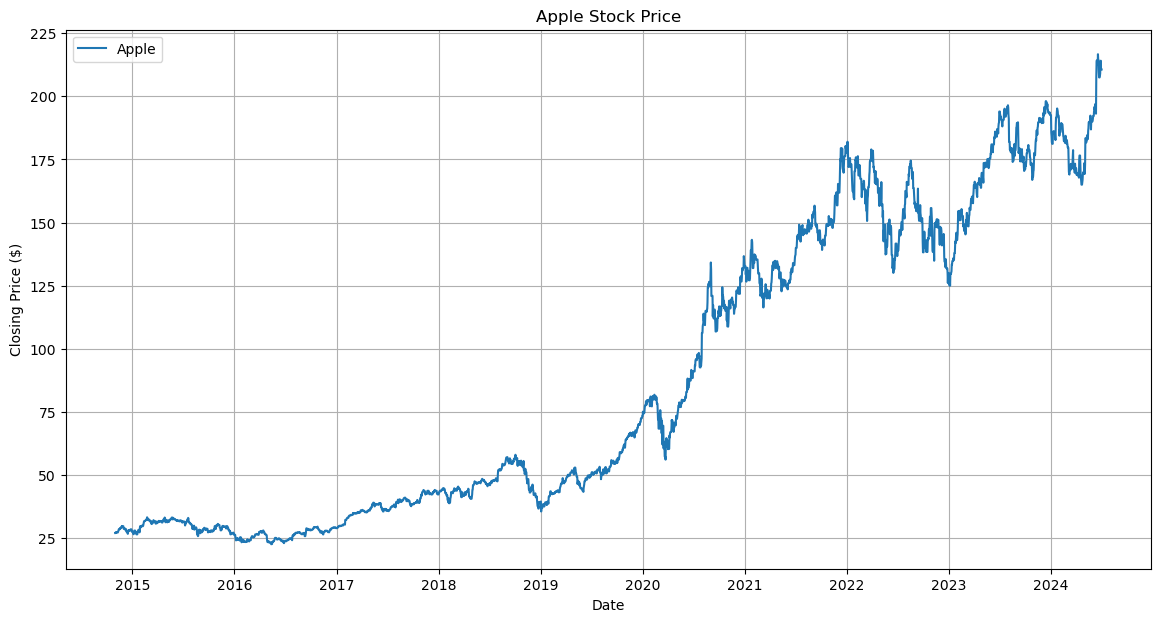

In [64]:
# 애플 주식 데이터 가져오기
# ticker = 'AAPL'
# apple = yf.Ticker(ticker)
# apple_df = apple.history(start='2014-01-01')
# apple_df.reset_index(inplace=True)
apple_df = stock_data[['Date', 'apple_Close']]

# 애플 주식 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(apple_df['Date'], apple_df['apple_Close'], label='Apple')

plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)

plt.show()

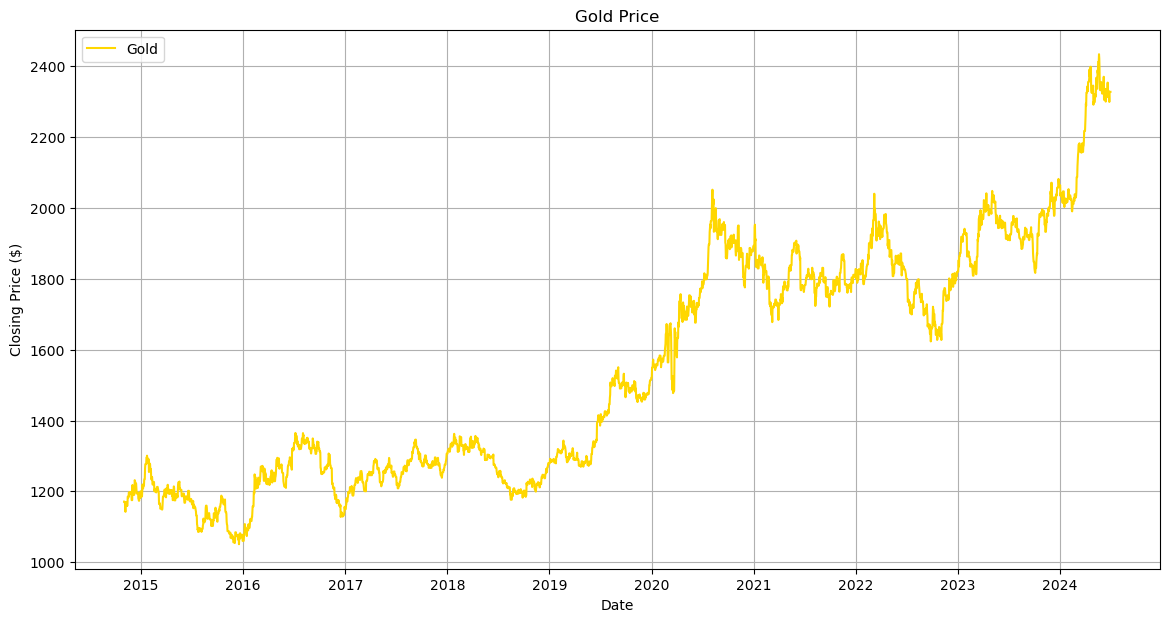

In [65]:
# 금 가격만 분할
gold_df = stock_data[['Date', 'gold_Close']]
# gold_df.loc[0, 'gold_Close'] = 1205.77
# gold_df

# 금 가격 그래프
plt.figure(figsize=(14, 7))
plt.plot(gold_df['Date'], gold_df['gold_Close'], label='Gold', color='gold')

plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)

plt.show()

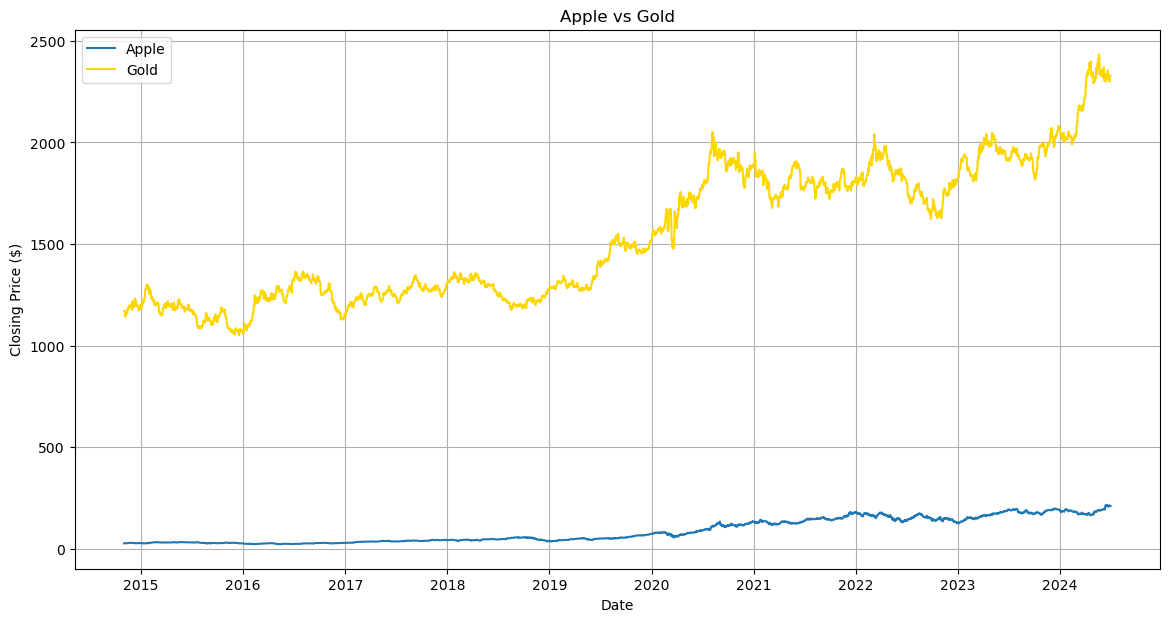

In [66]:
# 애플 주식과 금 가격 그래프
plt.figure(figsize=(14, 7))
plt.plot(apple_df['Date'], apple_df['apple_Close'], label='Apple')
plt.plot(gold_df['Date'], gold_df['gold_Close'], label='Gold', color='gold')

plt.title('Apple vs Gold')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)

plt.show()

In [67]:
# 0과 1 사이의 값으로 정규화
def normalize(df, column):
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [68]:
apple_normal_df = normalize(apple_df, 'apple_Close')
gold_normal_df = normalize(gold_df, 'gold_Close')

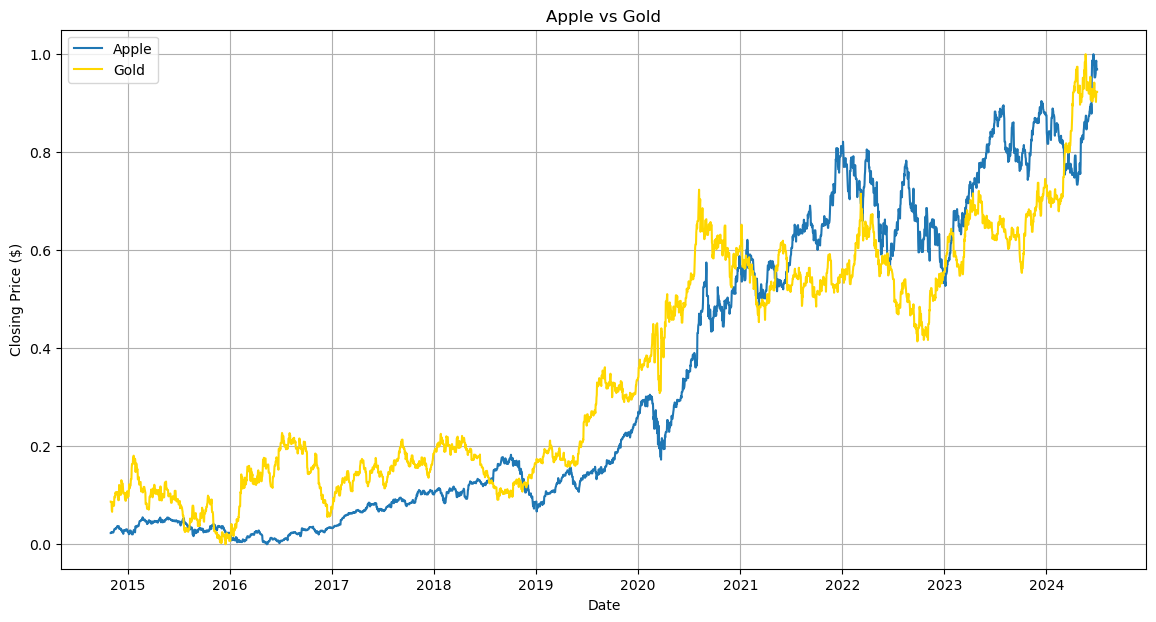

In [69]:
# 정규화 적용 애플 주식과 금 가격 그래프
plt.figure(figsize=(14, 7))
plt.plot(apple_df['Date'], apple_normal_df, label='Apple')
plt.plot(gold_df['Date'], gold_normal_df, label='Gold', color='gold')

plt.title('Apple vs Gold')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)

plt.show()

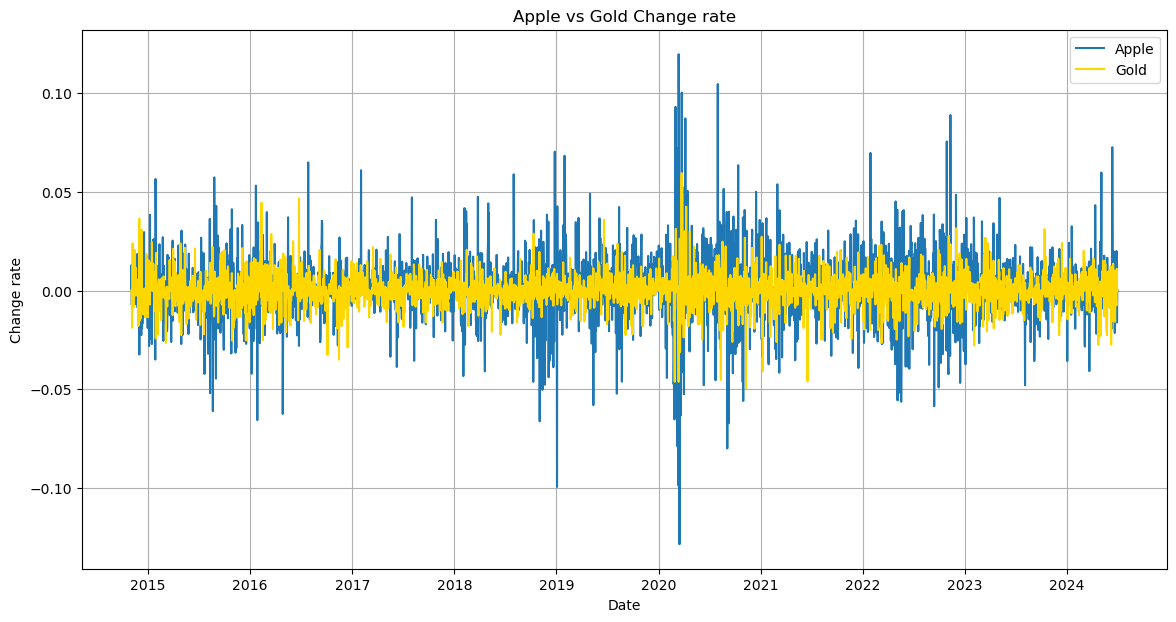

In [70]:
# 변동율 차이 비교

# 일간 변동률 계산 (판다스 함수 이용)  # shift(1) 이용하여 차이 게산도 가능
daily_change_apple_df = apple_df['apple_Close'].pct_change()
daily_change_gold_df = gold_df['gold_Close'].pct_change()

# 그래프화
plt.figure(figsize=(14, 7))
plt.plot(apple_df['Date'], daily_change_apple_df, label='Apple')
plt.plot(gold_df['Date'], daily_change_gold_df, label='Gold', color='gold')

plt.title('Apple vs Gold Change rate')
plt.xlabel('Date')
plt.ylabel('Change rate')
plt.legend()
plt.grid(True)

plt.show()

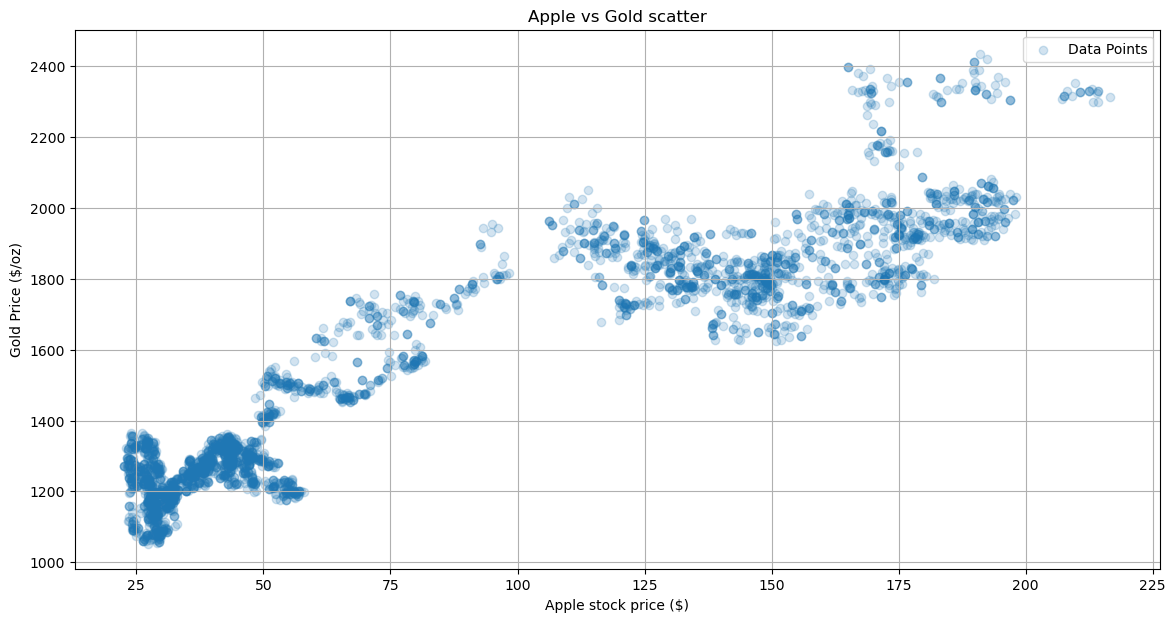

In [71]:
# 애플 주식과 금 값 데이터 병합

# 애플 Date컬럼 시간대 제거
# apple_df['Date'] = apple_df['Date'].dt.tz_localize(None)

merge_df = pd.merge(apple_df[['Date', 'apple_Close']], gold_df[['Date', 'gold_Close']], on='Date', how='inner')
# merged_df

# 산점도
plt.figure(figsize=(14, 7))
plt.scatter(merge_df['apple_Close'], merge_df['gold_Close'], alpha=0.2, label='Data Points')

# plt.xscale('log')  # X축에 로그 스케일 적용
# plt.yscale('log')  # Y축에 로그 스케일 적용

plt.title('Apple vs Gold scatter')
plt.xlabel('Apple stock price ($)')
plt.ylabel('Gold Price ($/oz)')
plt.legend()
plt.grid(True)

plt.show()

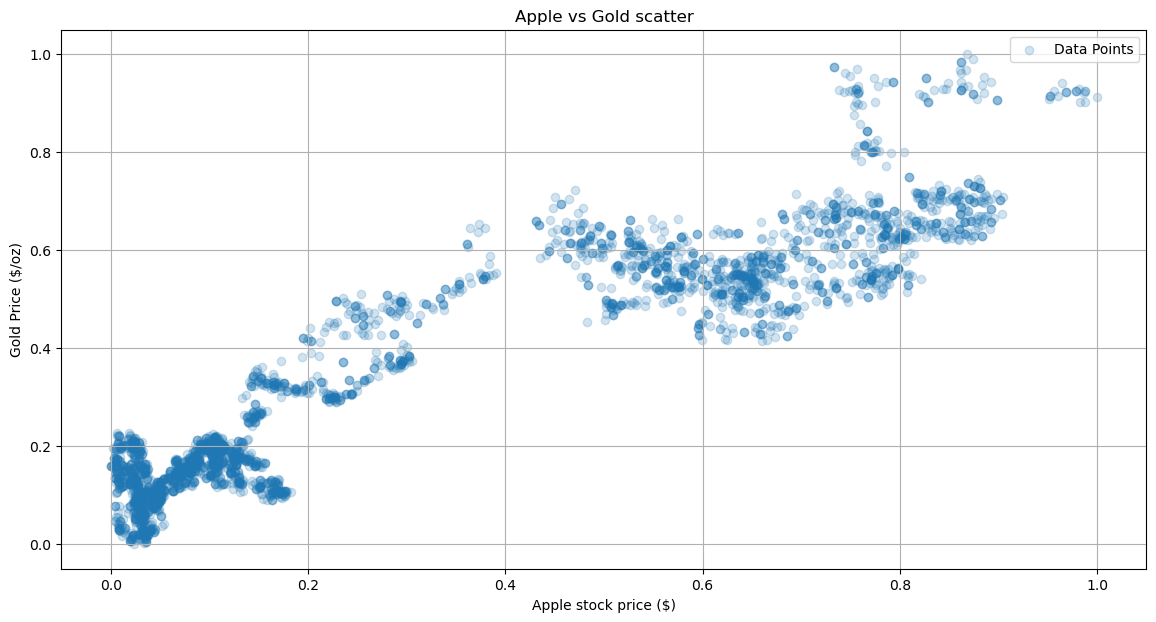

In [72]:
# 정규화 데이터 추가
merge_df['apple_normal'] = apple_normal_df
merge_df['gold_normal'] = gold_normal_df
# merge_df

# 산점도
plt.figure(figsize=(14, 7))
plt.scatter(merge_df['apple_normal'], merge_df['gold_normal'], alpha=0.2, label='Data Points')

plt.title('Apple vs Gold scatter')
plt.ylabel('Gold Price ($/oz)')
plt.xlabel('Apple stock price ($)')
plt.legend()
plt.grid(True)

plt.show()

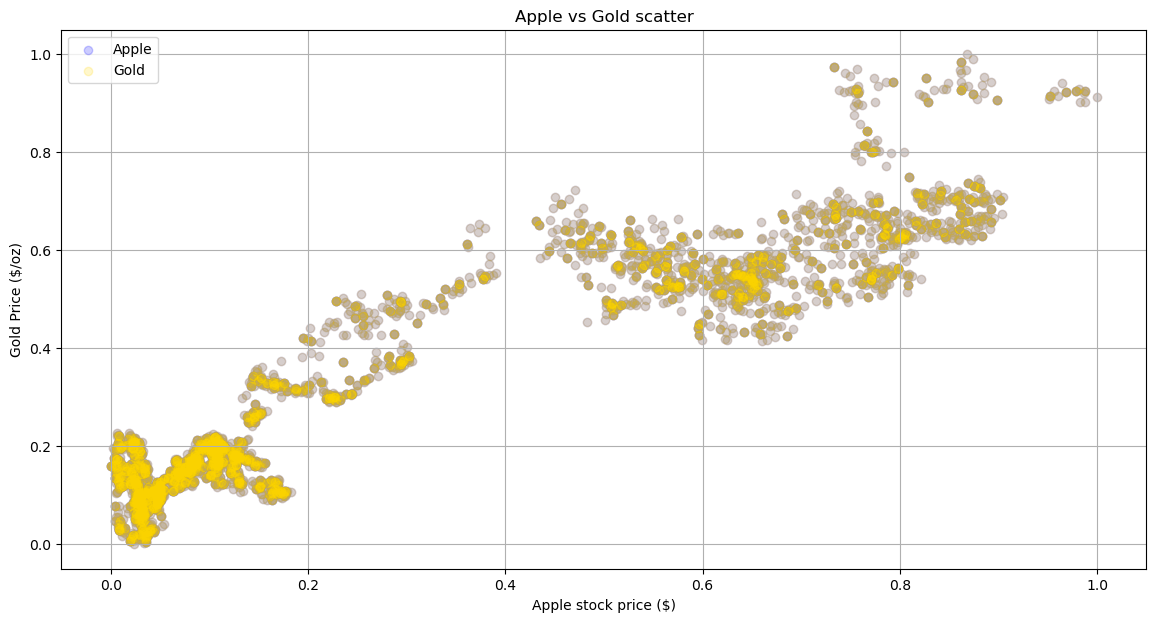

In [73]:
# 변동폭 데이터 추가
merge_df['apple_change_value'] = daily_change_apple_df
merge_df['gold_change_value'] = daily_change_gold_df
# merge_df

# 산점도
plt.figure(figsize=(14, 7))
plt.scatter(merge_df['apple_normal'], merge_df['gold_normal'], alpha=0.2, label='Apple', color='blue')
plt.scatter(merge_df['apple_normal'], merge_df['gold_normal'], alpha=0.2, label='Gold', color='gold')

plt.title('Apple vs Gold scatter')
plt.xlabel('Apple stock price ($)')
plt.ylabel('Gold Price ($/oz)')
plt.legend()
plt.grid(True)

plt.show()

In [74]:
# Calculate the correlation
correlation = merge_df['gold_Close'].corr(merge_df['apple_Close'])
print(f"Correlation between Gold Price and Apple Stock Price: {correlation:.2f}")

Correlation between Gold Price and Apple Stock Price: 0.94


In [75]:
compare1 = "apple"  # samsung, apple
compare2 = "금"
compare2data = "gold_Close"

In [76]:
# 필요한 데이터만 가져오기
df = stock_data[['Date', f'{compare1}_Close', f'{compare2data}', 'dollar_to_won_Close']]
df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])
df.head(3)

def normalize_data(series):
    # MinMaxScaler를 사용하여 데이터를 -1과 1 사이로 정규화
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1))

def Regression(compare1, compare2data, compare2):
    # 데이터 정규화
    stock_data[f'{compare1}_Close_Normalized'] = normalize_data(stock_data[f'{compare1}_Close'])
    stock_data[f'{compare2data}_Normalized'] = normalize_data(stock_data[f'{compare2data}'])

    # 선형 회귀 분석
    X = stock_data[f'{compare1}_Close_Normalized']
    y = stock_data[f'{compare2data}_Normalized']
    X = sm.add_constant(X)  # 상수항 추가
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # 회귀 분석 결과 출력
    print(model.summary())

    # 산점도 및 회귀선 그래프
    plt.scatter(stock_data[f'{compare2data}_Normalized'], stock_data[f'{compare1}_Close_Normalized'], label='Data points')
    plt.plot(stock_data[f'{compare2data}_Normalized'], predictions, color='red', label='Regression line')
    plt.xlabel(f'{compare2} (Normalized)')
    plt.ylabel(f'{compare1} (Normalized)')
    plt.legend()
    plt.show()

C:\Users\4호실-8\AppData\Local\Temp\ipykernel_10460\1423842406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])


In [77]:

def rolling_correlation_and_granger_test(compare1, compare2data, compare2, window_size=30, max_lag=5, stock_data=stock_data):
    col1 = f'{compare1}_Close'
    col2 = compare2data

    # 날짜 인덱스 설정
    if not pd.api.types.is_datetime64_any_dtype(stock_data.index):
        stock_data.index = pd.to_datetime(stock_data['Date'])
        stock_data = stock_data.drop(columns=['Date'])

    # 롤링 상관관계 계산
    rolling_corr = stock_data[col1].rolling(window=window_size).corr(stock_data[col2]).dropna()

    # 무한 값과 NaN 값 제거
    rolling_corr = rolling_corr[~rolling_corr.isin([np.inf, -np.inf])].dropna()

    # 롤링 상관관계 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr)
    plt.xlabel('Date')
    plt.ylabel('Rolling Correlation')
    plt.title(f'Dynamic Correlation between {col1} and {compare2}')
    plt.show()

    # 롤링 상관관계의 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(rolling_corr, bins=30, edgecolor='k')
    plt.xlabel('Rolling Correlation')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Rolling Correlations between {col1} and {compare2}')
    plt.show()

    # 그랜저 인과성 테스트
    granger_test_result = grangercausalitytests(stock_data[[col1, col2]], max_lag, verbose=True)

    return rolling_corr, granger_test_result

In [78]:
def Granger(compare1, compare2data, compare2, stock_data=stock_data):
    if f'{compare1}_Close' not in stock_data.columns or compare2data not in stock_data.columns:
        raise KeyError(f"Columns {compare1}_Close and/or {compare2data} not found in the provided DataFrame")
    
    max_lag = 2
    result1 = grangercausalitytests(stock_data[[f'{compare1}_Close', compare2data]], max_lag, verbose=True)
    result2 = coint_johansen(stock_data[[f'{compare1}_Close', compare2data]], det_order=-1, k_ar_diff=1)
    
    return result1, result2.lr1, result2.cvt


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.1648 , p=0.0000  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=18.1802 , p=0.0000  , df=1
likelihood ratio test: chi2=18.1336 , p=0.0000  , df=1
parameter F test:         F=18.1648 , p=0.0000  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.1103 , p=0.0000  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=20.2493 , p=0.0000  , df=2
likelihood ratio test: chi2=20.1914 , p=0.0000  , df=2
parameter F test:         F=10.1103 , p=0.0000  , df_denom=3523, df_num=2
                              OLS Regression Results                             
Dep. Variable:     gold_Close_Normalized   R-squared:                       0.875
Model:                               OLS   Adj. R-squared:                  0.875
Method:                    Least Squares   F-statistic:                 2.477e+04
Date:                   Thu, 08 Aug 2024   Prob (F-statistic):  

c:\Anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


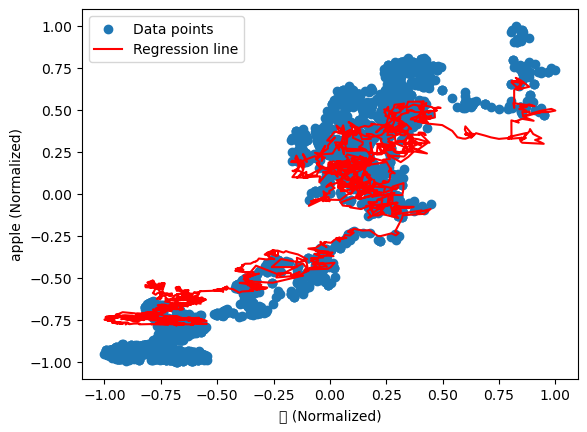

c:\Anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


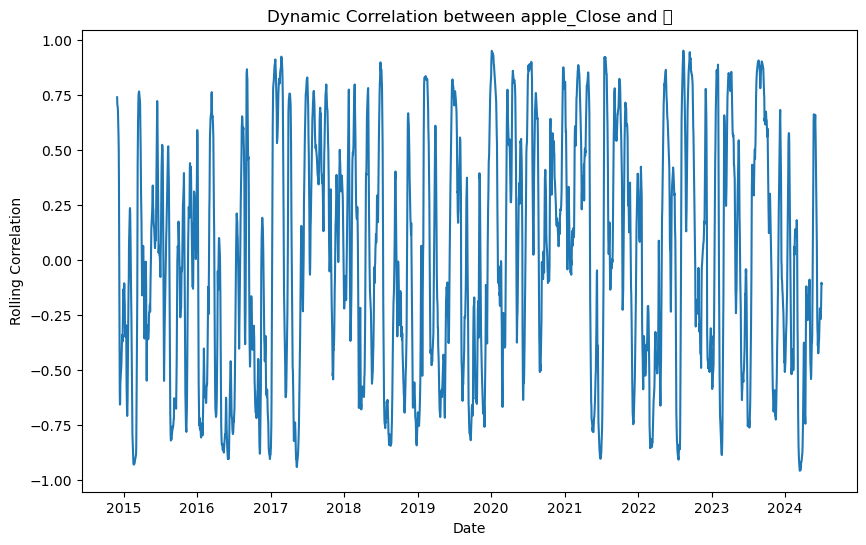

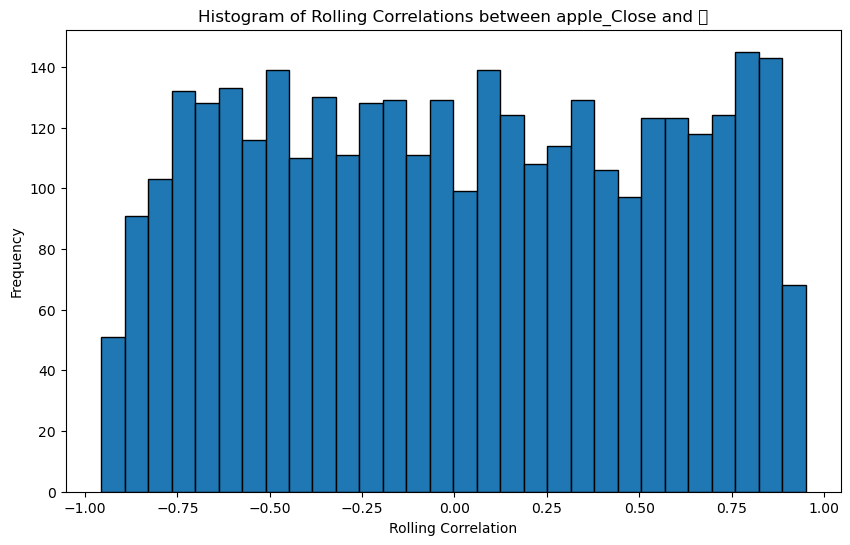


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.1648 , p=0.0000  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=18.1802 , p=0.0000  , df=1
likelihood ratio test: chi2=18.1336 , p=0.0000  , df=1
parameter F test:         F=18.1648 , p=0.0000  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.1103 , p=0.0000  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=20.2493 , p=0.0000  , df=2
likelihood ratio test: chi2=20.1914 , p=0.0000  , df=2
parameter F test:         F=10.1103 , p=0.0000  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7772  , p=0.0001  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=20.3721 , p=0.0001  , df=3
likelihood ratio test: chi2=20.3135 , p=0.0001  , df=3
parameter F test:         F=6.7772  , p=0.0001  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1084  , p=0.

c:\Anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [79]:
def everything(compare1, compare2data, compare2):
    Granger(compare1, compare2data, compare2)
    Regression(compare1, compare2data, compare2)
    rolling_correlation_and_granger_test(compare1, compare2data, compare2)
everything(compare1, compare2data, compare2)